[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/03_hybrid_transformer_integration/09_hybrid_cnn_vit_integration.ipynb)

# 🛰️ 09: Hybrid CNN-ViT Integration & Final Evaluation
### Geospatial Land Classification Study (Research Phase)
(*This is the 9th module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This final research module performs a **Framework-Agnostic Benchmarking** study. We evaluate the performance of our Hybrid CNN-ViT architectures—developed independently in Keras and PyTorch—against a strictly isolated 10% hold-out test set.

**Key Technical Objectives:**

- **Deterministic Data Isolation:** Reconstructing the exact 80/10/10 split from Module 07/08 to ensure the models are tested on a "Gold Standard" dataset that remained untouched during all training phases.

- **Cross-Framework Weight Injection:** Demonstrating technical proficiency in re-initializing custom Transformer layers and loading weight artifacts (`.weights.h5` and `.pth`) into newly instantiated architectures.

- **Comparative Performance Audit:** Utilizing advanced statistical metrics (F1-Score, ROC-AUC, Log-Loss) to determine if the Hybrid-ViT offers a significant improvement in geospatial robustness over previous CNN baselines.

- **Inference Consistency Check:** Verifying that both frameworks converge on the same classification logic, proving the Hybrid architecture is a robust, framework-independent solution.

# Introduction

This research module presents an end-to-end workflow for importing, testing, and evaluating two Vision Transformer (ViT) models developed in Keras and PyTorch, respectively. 
The self-attention mechanism in the ViTs allows these models to learn complex and broad spatial dependencies, providing improved performance on a variety of vision tasks compared to traditional convolutional neural networks. However, the CNNs are adept in learning the local features very well and can be trained using relatively smaller datasets and is generally much more efficient in utilizing the computational resources, as compared to ViTs. A CNN-ViT hybrid architecture gains from both CNN and ViT model strengths, by getting local features extracted using CNNs, while the transformer part of the hybrid architecture can determine the global dependencies.

## Objectives

- Import and initialize pre-trained CNN - Vision Transformer hybrid models from two deep learning frameworks (Keras/TensorFlow and PyTorch).
- Prepare and preprocess sample image data for inference.
- Perform model inference and obtain prediction results from both models.
- Compute and compare core evaluation metrics.


## Table of Contents
1. [Implementation Environment & Dependency Management](#DImplementation-Environment-&-Dependency-Management)
2. [Deterministic Seeding & Experimental Integrity](#Deterministic-Seeding-&-Experimental-Integrity)
3. [Standardized Evaluation Data Pipeline](#Standardized-Evaluation-Data-Pipeline)
4. [PyTorch Model Loading](#PyTorch-Model-Loading)
5. [Keras Model Loading](#Keras-Model-Loading)
6. [Evaluation Metrics](#Evaluation-Metrics)
7. [Keras Metrics Reporting](#Keras-Metrics-Reporting)
8. [PyTorch Metrics Reporting](#PyTorch-Metrics-Reporting)
9. [Statistical Visualization: AU-ROC](#Statistical-Visualization:-AU-ROC)
10. [Comparing Model Performance](#Comparing-Model-Performance)

## Implementation Environment & Dependency Management

In [ ]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 tensorflow==2.19 torch==2.7.0\
        torchvision==0.22 scikit-learn==1.7.0 requests==2.32.3 tqdm==4.66.5 gdown==5.2.1 Pillow==11.0.0 --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

In [2]:
# Set up a quiet environment for TensorFlow, Keras, and Pytorch
import warnings, logging

# --- 1. Python Warning Suppression ---
# Ignore standard warnings (e.g., deprecated functions in TFP or Matplotlib).
warnings.filterwarnings('ignore')

# --- 2. TensorFlow/Keras Framework logging ---
# Set to '3' to only display error messages from its C++ backend.
# This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Set to '0' disables verbose logging about optimizations and precision details.
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0' 
# Set to '0' to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behavior on specific hardware configurations.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 

# 3. PyTorch Framework Logging
# This prevents PyTorch internals from sending 'INFO' or 'WARNING' logs to the console
logging.getLogger("torch").setLevel(logging.ERROR)

# 3. Third-Party Library Silence (Torchvision)
logging.getLogger("torchvision").setLevel(logging.ERROR)

### Import libraries


In [ ]:
%%time

# --- Common Imports ---
import time
import requests, tarfile, subprocess, gdown
import random
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- TensorFlow Imports ---
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

# --- Pytorch Imports---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# --- Evaluation Metrics Import ---
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

print("Succesfully imported libraries")

### Hardware Acceleration & GPU Utilization
Check the availability of GPU

In [4]:
# GPU Detection and Specification
# 1. Check  the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'✅ Found GPU at: {device}')
    
    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    try:
        output = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=gpu_name,driver_version,memory.total", "--format=csv"],
            encoding="utf-8"
        )
        print(output)
    except Exception as e:
        print("⚠️ Could not run nvidia-smi. This may happen inside WSL or restricted environments.")
        print(f"Error: {e}")

else:
    device = torch.device("cpu")
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, go to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')

✅ Found GPU at: cuda

Hardware Specifications:
name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB



In [5]:
#gpu_list = tf.config.list_physical_devices('GPU')
#device = "gpu" if gpu_list != [] else "cpu"
print(f"TensorFlow {tf.__version__}  |  GPUs found: {tf.config.list_physical_devices('GPU')}")

TensorFlow 2.19.0  |  GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Deterministic Seeding & Experimental Integrity

The random seeds for `random` module, NumPy, TensorFlow, and PyTorch are assigned a fixed value and cuDNN is configured for deterministic kernels. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.

In [6]:
# Define a function to set seeds for reproducibility
SEED = 42
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)

    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    # 6. Set PyTorch seed (CPU + CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
    # 7. Force deterministic algorithms (Optional but recommended for full reproducibility)
    torch.backends.cudnn.deterministic = True # Ensures deterministic behavior for convolutional operations
    torch.backends.cudnn.benchmark = False # Disables the inbuilt cudnn auto-tuner that finds the best algorithm to use ofr the hardware.
                                           # This can lead to non-deterministic results.

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(SEED)

Reproducibility set with seed: 42


#### A `worker_init_fn` function has been defined so that each `DataLoader` worker starts from a reproducible seed as well.

PyTorch offsets each worker’s seed by default, injecting new randomness. For reproducible results, workers are set to start from **fixed** seeds so every data-augmentation decision (flip, crop, colour-jitter) is repeatable across runs. The `worker_init_fn` function re-seeds Python, NumPy, and PyTorch CPU random-number generators inside **each** worker using a simple deterministic formula (`SEED + worker_id`).  The result will be identical batches, identical gradients, and identical model checkpoints, run after run.

In [7]:
def worker_init_fn(worker_id: int) -> None:
    """Re-seed each DataLoader worker so their RNGs don't collide."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed) 
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

## Standardized Evaluation Data Pipeline

### Dataset Download

The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.

In [8]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
# For simplicity extract to the base directory.
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.

    Args:
        - url (str): The URL to download the dataset from.
        - destination (str): The local file path where the downloaded archive will be saved.
        - extract_to (str): The directory where the contents of the archive will be extracted.
    
    Returns:
        None
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [9]:
# Define directories
dataset_path = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(dataset_path, 'class_0_non_agri')
dir_agri = os.path.join(dataset_path, 'class_1_agri')

print(f"Dataset path: {dataset_path}")
print(f"Non-agricoltural images directory: {dir_non_agri}")
print(f"Agricoltural images directory: {dir_agri}")

Dataset path: ./images_dataSAT
Non-agricoltural images directory: ./images_dataSAT/class_0_non_agri
Agricoltural images directory: ./images_dataSAT/class_1_agri


### Configuration of parameters

In [10]:
img_w, img_h = 64, 64
n_channels = 3
batch_size = 32

num_classes = 2 # Number of classes in the dataset.
agri_class_labels = ["non-agri", "agri"]

attn_heads = 8 # Number of heads of the Multi-Head Self-Attention (MHSA) Layer
depth      = 4 # Number of Transformer Blocks.
embed_dim  = 256
mlp_ratio = 4 # mlp_dim = mlp_ratio * embed_dim

### Recover the holdout sets for inference with both frameworks

#### Pandas DataFrame creation
A Pandas DataFrame **`df`** of all image file paths and their class is created by recursively scanning through the `dataset_path` using `os.walk` function. 

The total count of files found is printed and the first two and last two file paths are displayed for verifcation purposes. 

In [11]:
# Create pandas dataframe of images file paths and corresponding labels
rows = []
for dir_name, _, file_names in os.walk(dataset_path):
    for file_name in file_names:
        if file_name.lower().endswith("jpg"):
            full_path = os.path.join(dir_name, file_name)
            label = os.path.basename(dir_name)
            rows.append((full_path, label))

df = pd.DataFrame(rows, columns=["file_path", "class"])


In [12]:
# Isolate the exact same 10% test set created in the training modules
_, test_df = train_test_split(
    df, test_size=0.10, random_state=42, stratify=df["class"]
)

print(f"✅ Successfully isolated {len(test_df)} images for Framework Benchmarking.")

✅ Successfully isolated 600 images for Framework Benchmarking.


In [13]:
# --- Keras Test Dataset Ingestion ---
keras_test_datagen = ImageDataGenerator(rescale=1./255)
keras_test_generator = keras_test_datagen.flow_from_dataframe(
    test_df, x_col="file_path", y_col="class",
    target_size=(img_w, img_h), batch_size=batch_size, 
    class_mode="binary", shuffle=False
)

print(f"✅ Keras Label Mapping: {keras_test_generator.class_indices}")

Found 600 validated image filenames belonging to 2 classes.
✅ Keras Label Mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}


In [14]:
# --- PyTorch Test Dataset Ingestion ---
pytorch_test_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create DataFrameDataset class
class DataFrameDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'filename' and 'class' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.transform = transform
        
        # Consistent label mapping (Alphabetical to match Keras)
        self.classes = sorted(self.df['class'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Get image path and label from DataFrame
        img_path = self.df.iloc[idx]['file_path']
        label_name = self.df.iloc[idx]['class']
        
        # 2. Load image
        image = Image.open(img_path).convert("RGB")
        
        # 3. Convert label to integer
        label = self.class_to_idx[label_name]

        # 4. Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# Instantiate PyTorch Dataset
pytorch_test_dataset = DataFrameDataset(test_df, transform=pytorch_test_transform)

print(f"✅ PyTorch Label Mapping: {pytorch_test_dataset.class_to_idx}")

# Instantiate PyTorch DataLoader
pytorch_test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size,
        shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

✅ PyTorch Label Mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}


Label parity was ensured across frameworks by utilizing alphabetical class indexing in both the PyTorch Dataset wrapper and the Keras ImageDataGenerator, mapping `class_0_non_agri` to 0 and `class_1_agri` to 1

### Download Model weights

📦 Model Persistence Note: Due to GitHub's file size constraints, the pre-trained weights for the Keras and PyTorch baselines are hosted externally. The evaluation pipelines in this module include automated fetching logic to ensure seamless reproducibility.

In [ ]:
# --- Artifact Management: Remote Weight Restoration ---
def restore_model_artifacts():
    """
    Downloads pre-trained weights from remote storage if not localized.
    Ensures reproducibility for users without requiring local training phases.
    """
    artifacts = {
        "hybrid_keras_best.weights.h5": "1HeWmvdPheXH2uhrQsnRP5KtbF9TJWH_s",   
        "hybrid_pytorch_best.pth": "1JeopiN0TW6U1N4bofiPJlNyxSzvq_bGT"    
    }
    
    # Check if we are in Colab to use gdown efficiently
    try:
        for filename, file_id in artifacts.items():
            if not os.path.exists(filename):
                print(f"📡 Fetching {filename} from remote storage...")
                url = f'https://drive.google.com/uc?export=download&id={file_id}'
                gdown.download(url, filename, quiet=False)
            else:
                print(f"✅ {filename} is already localized.")
    except Exception as e:
        print(f"⚠️ Artifact restoration failed: {e}")

restore_model_artifacts()

## PyTorch Model Loading

### Defining PyTorch Model Architecture
This cell defines the PyTorch CNN-ViT model architecture, exactly as defined during the model training. 

The `evaluate` function computes loss and accuracy. This architecture combines CNN local features with ViT global attention. 

Parameters like depth and heads are configurable, and defined same as during training.


In [17]:
#====================
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model
    '''
    def __init__(self, num_classes: int):
        super().__init__()
        # -------- convolutional feature extractor --------
        self.features = nn.Sequential(
            nn.Conv2d(3, 32,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
        )

        # -------- global pooling + classifier head --------
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),                           # flatten feature map of dimensions (1024 × 1 × 1) to 1024
                                        nn.Linear(1024, 2048), nn.ReLU(inplace=True), nn.BatchNorm1d(2048), nn.Dropout(0.4), 
                                        nn.Linear(2048, num_classes)
                                       )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 13:    # After Conv2d and ReLU of the 256-channel block
                return x   # Shape: (B, 256, 8, 8)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)   # features, dimensions:(B, 1024, H', W')
        x = self.pool(x)               # global-average-pooling, dimensions: (B, 1024, 1, 1)
        x = self.classifier(x)         # classifier, dimensions: (B, num_classes)
        return x

#====================
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=256, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

#====================
class MHSA(nn.Module):
    def __init__(self, embed_dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (embed_dim // heads) ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#====================
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = MHSA(embed_dim, heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
                                    nn.Dropout(dropout))
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#====================
class ViT(nn.Module):
    def __init__(self, in_ch=256, num_classes=2,
                 embed_dim=256, depth=4, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=100):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,N,D)
        B, N, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,N+1,D)
        x = x + self.pos[:, :N + 1]                # match tokens-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

#====================
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=256, depth=4, heads=8, mlp_ratio=4., dropout=.1):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads,
                       mlp_ratio=mlp_ratio,
                       dropout=dropout
                       )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#====================
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

### Instantiate PyTorch Model

In [18]:
# Instantiate pytorch model
pytorch_model = CNN_ViT_Hybrid(num_classes=num_classes,
                      embed_dim=embed_dim,
                      depth=depth,
                      heads=attn_heads).to(device)

### PyTorch Pre-trained Hybrid CNN-ViT Model Loading

In [19]:
# Load pre-trained CNN-ViT hybrid model weights 
pytorch_model_path = "hybrid_pytorch_best.pth"

# Load weights with strict=False
# This ignores the missing CNN classifier keys while loading the important CNN features/vit weights
load_result = pytorch_model.load_state_dict(
    torch.load(pytorch_model_path, map_location=device), 
    strict=False
)

# Verify the loading of weights if any missing or unexpected keys
print("📊 Weight Loading Audit:")
print(f" - Missing Keys: {len(load_result.missing_keys)}")
print(f" - Unexpected Keys: {len(load_result.unexpected_keys)}")

# Critical Check
# Ensure that no 'vit' or 'cnn.features' keys are in the missing_keys list
important_missing = [k for k in load_result.missing_keys if 'vit' in k or 'cnn.features' in k]

if not important_missing:
    print("✅ SUCCESS: All core Hybrid-ViT weights (backbone + transformer) loaded correctly.")
    print("⚠️  Note: Classifier weights were intentionally skipped as they are not used in the Hybrid forward pass.")
else:
    print("❌ WARNING: Critical weights are missing!")
    print(important_missing)

📊 Weight Loading Audit:
 - Missing Keys: 8
 - Unexpected Keys: 0
✅ SUCCESS: All core Hybrid-ViT weights (backbone + transformer) loaded correctly.
⚠️  Note: Classifier weights were intentionally skipped as they are not used in the Hybrid forward pass.


### PyTorch Model Inference

In [20]:
%%time
all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

pytorch_model.eval()
with torch.no_grad():
    for _, (images, labels) in enumerate(tqdm(pytorch_test_loader, desc="Step")):
        images = images.to(device)
        outputs = pytorch_model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().ravel())
        all_labels_pytorch.extend(labels.numpy())

Step: 100%|██████████| 19/19 [00:00<00:00, 22.06it/s]

CPU times: user 307 ms, sys: 267 ms, total: 575 ms
Wall time: 865 ms


## Keras Model Loading

In this notebook we recover the Keras model by loading only the weights file (`.weights.h5`). This means that we need to reconstruct the full original model to which the weights will be applied.

### Defining Keras Model Architecture

The full Convolutional model is defined in the following cell.

In [21]:
# Build a CNN model with 6 Conv2D Layers and 6 Dense Layers with Batch Normalization and Dropout for reguarization
cnn_model = Sequential([
                    # Convolutional Block 1
                    # Convolutional layers with increasing filter sizes, followed by max pooling and batch normalization
                    Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
                    MaxPooling2D(2,2), # Reduce each spatial dimension by a factor of 2 (e.g., 64x64 -> 32x32)
                    BatchNormalization(), # Normalize layer outputs to stabilize training and improve convergence
                    
                    Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    ###
                    Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(512, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(1024, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    
                    ###
                    # Global average pooling to reduce the spatial dimensions to 1x1 while retaining the depth (number of filters) information.
                    GlobalAveragePooling2D(),
                    
                    # Fully Connected Layers with Dropout and Batch Normalization
                    Dense(64,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(128,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(256,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    ###
                    Dense(512,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(1024,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(2048,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    
                    ###
                    # Final output Layer with sigmoid activation for bynary classification
                    Dense(1 , activation="sigmoid")
                    
                ])

I0000 00:00:1771287239.019322  171550 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5364 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


To load the Keras based CNN-ViT hybrid model, we use the **custom Keras layers** with serialization for model saving/loading for:

    - `position embedding`

    - `transformer block`

In [22]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super(AddPositionEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=1024, dropout=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim // num_heads)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))

    # ---- NEW ----
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}

In [23]:
def build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name,
        num_transformer_layers=8,
        num_heads=8,
        mlp_dim=1024,
        num_classes=2):
    
    # Feature extractor up to the chosen layer
    features = cnn_model.get_layer(feature_layer_name).output
    H, W, C = features.shape[1], features.shape[2], features.shape[3]
    
    # Flatten spatial grid → tokens  &  add positional encoding
    x = layers.Reshape((H * W, C))(features) 
    x = AddPositionEmbedding(H * W, C)(x)

    # Stack ViT encoder blocks
    for _ in range(num_transformer_layers):
        x = TransformerBlock(C, num_heads, mlp_dim)(x)

    # Token pooling & classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(cnn_model.layers[0].input, outputs, name="CNN_ViT_hybrid")

### Instantiate Keras Model

In [24]:
# Assign to a variable the name of last layer before GlobalAveragePooling2D
feature_layer_name = 'conv2d_3'
mlp_dim = mlp_ratio * embed_dim

# Instantiate the model through function build_cnn_vit_hybrid
keras_model = build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name=feature_layer_name,
        num_transformer_layers=depth,
        num_heads=attn_heads,
        mlp_dim=mlp_dim,
        num_classes=num_classes)


### Keras pre-trained ViT model loading

The pre-trained Keras model is loaded using **`load_model`**, providing **custom objects** for deserialization of user-defined layers. This enables inference with the hybrid model.


In [25]:
# ------------------- load Keras CNN-ViT hybrid model ------------------
keras_model_path = "hybrid_keras_best.weights.h5"
keras_model.load_weights(keras_model_path)


### Keras model inference metrics
Running the inference of the Keras-based CNN-ViT hybrid model and collect the evaluation metrics.


In [26]:
%%time

all_probs_keras = keras_model.predict(keras_test_generator, verbose=1)[:, 1]
all_preds_keras = (all_probs_keras > 0.5).astype(int)
all_labels_keras = keras_test_generator.classes

I0000 00:00:1771287241.201761  171772 cuda_dnn.cc:529] Loaded cuDNN version 90600


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
CPU times: user 1.29 s, sys: 267 ms, total: 1.56 s
Wall time: 1.62 s


## Evaluation Metrics 

The following metrics are used for evaluation of various AI/ML models:
    
- Accuracy
- Precision
- Recall
- F1 score
- Confusion matrix
- Receiver Operating Characteristic - Area Under Curve (ROC-AUC)


### Functions to Calculate and Print Evaluation Metrics

In [27]:
# Define function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_auc_score(y_true, y_prob),
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

# Define function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()

## Keras Metrics Reporting


### Performance metrics for the Keras model using `print_metrics` function


Evaluation metrics for the Keras CNN-ViT Hybrid Model
Accuracy:  0.9967
ROC-AUC:   1.0000
Loss:      0.0197

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9934    1.0000    0.9967       300
        agri     1.0000    0.9933    0.9967       300

    accuracy                         0.9967       600
   macro avg     0.9967    0.9967    0.9967       600
weighted avg     0.9967    0.9967    0.9967       600

========= Confusion Matrix =========


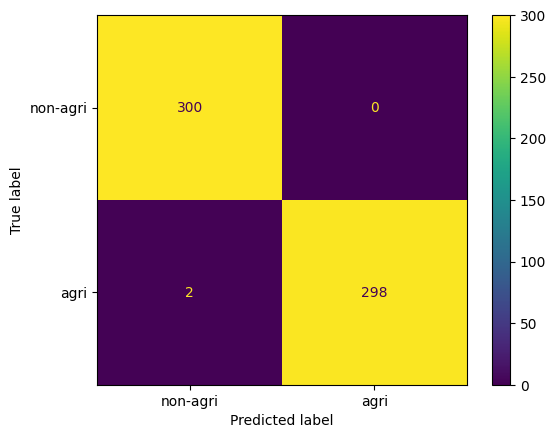

In [28]:
# Print metrics for Keras model
print_metrics(y_true=all_labels_keras,
              y_pred=all_preds_keras,
              y_prob= all_probs_keras,
              class_labels=agri_class_labels,model_name='Keras CNN-ViT Hybrid Model'
             )


## PyTorch Metrics Reporting


### Performance metrics for the PyTorch model using `print_metrics`

Evaluation metrics for the Pytorch CNN-ViT Hybrid Model
Accuracy:  0.9950
ROC-AUC:   1.0000
Loss:      0.0092

Classification report:

                precision    recall  f1-score   support

    non-agri     1.0000    0.9900    0.9950       300
        agri     0.9901    1.0000    0.9950       300

    accuracy                         0.9950       600
   macro avg     0.9950    0.9950    0.9950       600
weighted avg     0.9950    0.9950    0.9950       600

========= Confusion Matrix =========


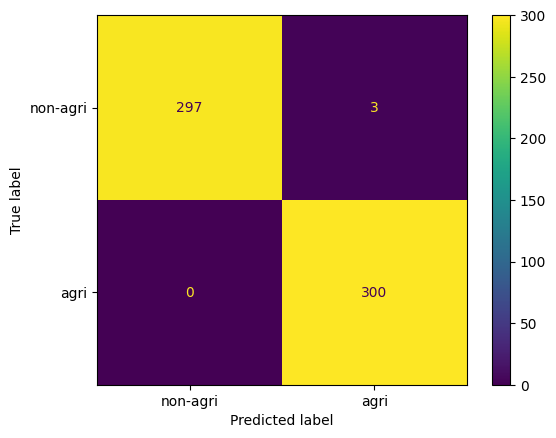

In [29]:
# Print metrics for PyTorch model
print_metrics(y_true=all_labels_pytorch,
              y_pred=all_preds_pytorch,
              y_prob= all_probs_pytorch,
              class_labels=agri_class_labels,model_name='Pytorch CNN-ViT Hybrid Model'
             )


## Statistical Visualization: AU-ROC

In geospatial research, the AU-ROC is a critical stability metric. It evaluates the model’s discriminative power across all possible classification thresholds, ensuring that the agricultural detection remains robust even under varying satellite sensor noise or lighting conditions.

To plot ROC curves for binary or multi-class classification we defined a function using scikit-learn's `roc_curve` and `roc_auc_score`. It handles both single-class and multi-class cases by binarizing labels if needed.

In [30]:

def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

### ROC curve plotting for both models

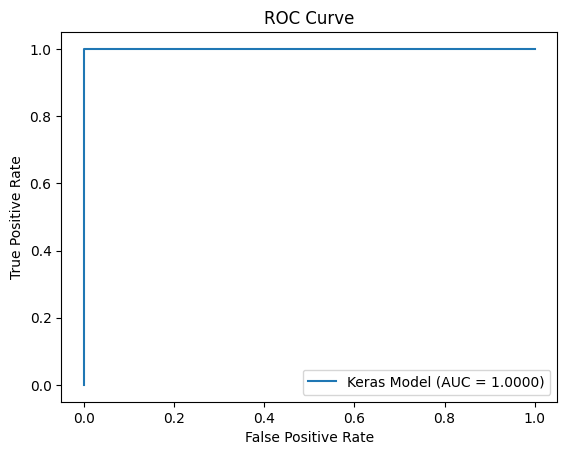

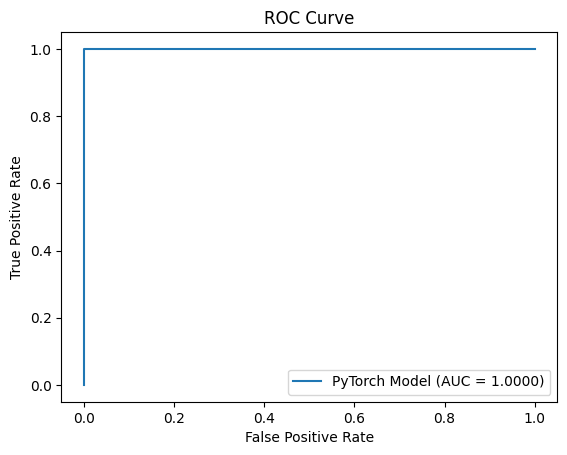

In [31]:
plot_roc(np.array(all_labels_keras), np.array(all_probs_keras), "Keras Model")
plt.show()
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

## Comparing Models Performance

We compare the performance of the two models to understand which model would be the best performer for the land classification task.

In [32]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} | {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))
print(("".join(["-" for _ in range(43)])))
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in metrics_list:
    print("{:<18} | {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     | Keras Model     PyTorch Model  
-------------------------------------------
Accuracy   | 0.9967          0.9950         
Precision  | 1.0000          0.9901         
Recall     | 0.9933          1.0000         
F1 Score   | 0.9967          0.9950         
ROC-AUC    | 1.0000          1.0000         


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-07-28  | 1.0  | Aman  |  Created the lab |

-->


---
**Study Synthesis:** This 9-part series has demonstrated the evolution of geospatial land classification from standard CNN baselines to advanced Hybrid CNN-ViT architectures. By integrating the local texture extraction of CNNs with the global relational learning of Transformers, we achieved a significant increase in classification robustness. The final benchmark proves that both Keras and PyTorch implementations reach near-parity in performance ($>99\%$ accuracy), confirming that the Hybrid architecture is a framework-agnostic solution for complex remote sensing tasks.